# **Load Dependencies**

In [1]:
!pip install pycaret

     |████████████████████████████████| 288 kB 5.1 MB/s 
     |████████████████████████████████| 2.0 MB 62.0 MB/s 
     |████████████████████████████████| 56 kB 1.6 MB/s 
     |████████████████████████████████| 167 kB 51.9 MB/s 
     |████████████████████████████████| 1.7 MB 39.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 261 kB 45.3 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 6.8 MB 28.5 MB/s 
     |████████████████████████████████| 15.5 MB 427 kB/s 
     |████████████████████████████████| 113 kB 49.1 MB/s 
     |████████████████████████████████| 1.3 MB 43.3 MB/s 
     |████████████████████████████████| 596 kB 42.9 MB/s 
     |████████████████████████████████| 303 kB 40.9 MB/s 
     |████████████████████████████████| 675 kB 57.2 MB/s 
     |██████████████████

In [2]:
import pandas as pd
from pycaret.clustering import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Load Data**

In [4]:
root_path = "/content/gdrive/MyDrive/Kmean/Supermarket Data.csv"
df = pd.read_csv(root_path)

In [5]:
df['SHOP_DATE'] = df['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [6]:
df.tail(5)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
956569,200617,2006-06-22,5,12,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,NaN,NaN,NaN,994101100088778,M,MM,Top Up,Fresh,STORE00002,LS,W01
956570,200633,2006-10-13,6,20,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,NaN,NaN,NaN,994102700099738,L,LA,Top Up,Fresh,STORE00002,LS,W01
956571,200617,2006-06-22,5,18,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000544241,LA,YA,994101100506174,L,LA,Top Up,Fresh,STORE00002,LS,W01
956572,200619,2006-07-06,5,19,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000423155,LA,YF,994101300433650,L,LA,Full Shop,Fresh,STORE00002,LS,W01
956573,200635,2006-10-23,2,21,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,NaN,NaN,NaN,994102900104676,L,MM,Top Up,Fresh,STORE00002,LS,W01


In [7]:
df.info

<bound method DataFrame.info of         SHOP_WEEK  SHOP_DATE  SHOP_WEEKDAY  SHOP_HOUR  QUANTITY  SPEND  \
0          200732 2007-10-05             6         17         3   6.75   
1          200733 2007-10-10             4         20         3   6.75   
2          200741 2007-12-09             1         11         1   2.25   
3          200731 2007-09-29             7         17         1   2.25   
4          200737 2007-11-10             7         14         3   6.75   
...           ...        ...           ...        ...       ...    ...   
956569     200617 2006-06-22             5         12         3   3.96   
956570     200633 2006-10-13             6         20         3   3.96   
956571     200617 2006-06-22             5         18         3   3.96   
956572     200619 2006-07-06             5         19         3   3.96   
956573     200635 2006-10-23             2         21         3   3.96   

         PROD_CODE PROD_CODE_10 PROD_CODE_20 PROD_CODE_30 PROD_CODE_40  \
0    

# **Prepare customer single view**

# Define features

Total visits = COUNT(DISTINCT BASKET ID)

Ticket size = SUM(SPEND)/COUNT(DISTINCT BASKET ID)

Total no. of SKUs


# Calculate features

In [8]:
##prepare customer single view
df_csv = df_groupby = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE']).agg(TotalSpend=('SPEND', 'sum'),
                                                                                  TotalVisits=('BASKET_ID', 'nunique'),
                                                                                  TotalSKUs=('PROD_CODE', 'nunique'),
                                                                                  FirstDate=('SHOP_DATE', 'min'),
                                                                                  LastDate=('SHOP_DATE', 'max'),
                                                                                  Life=('CUST_LIFESTAGE', 'min'),
                                                                                  ).reset_index()

In [9]:
#Create LifeStage feature
df_csv['LifeStage'] = pd.factorize(df_csv['Life'])[0] + 1

In [10]:
#Create BasketType feature
df_test3  = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE','BASKET_TYPE']).agg(BasketCount=('BASKET_TYPE', 'count')).reset_index()
df_test3['BasketType'] = pd.factorize(df_test3['BASKET_TYPE'])[0] + 1
idx = df_test3.groupby(['CUST_CODE'])['BasketCount'].transform(max)== df_test3['BasketCount']
df_test3 = df_test3[idx].groupby('CUST_CODE').first()

In [11]:
#Create BasketDOM feature
df_test4  = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE','BASKET_DOMINANT_MISSION']).agg(DomCount=('BASKET_DOMINANT_MISSION', 'count')).reset_index()
df_test4['BasketDom'] = pd.factorize(df_test4['BASKET_DOMINANT_MISSION'])[0] + 1
idx = df_test4.groupby(['CUST_CODE'])['DomCount'].transform(max)== df_test4['DomCount']
df_test4 = df_test4[idx].groupby('CUST_CODE').first()

In [12]:
#Create Weekday feature
df_test  = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE','SHOP_WEEKDAY']).agg(CountWeekday=('SHOP_WEEKDAY', 'count')).reset_index()
idx = df_test.groupby(['CUST_CODE'])['CountWeekday'].transform(max)== df_test['CountWeekday']
df_test = df_test[idx].groupby('CUST_CODE').first()


In [13]:
# Create ShopHour feature
df_test2  = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE','SHOP_HOUR']).agg(CountHour=('SHOP_HOUR', 'count')).reset_index()
idx = df_test2.groupby(['CUST_CODE'])['CountHour'].transform(max) == df_test2['CountHour']
df_test2 = df_test2[idx].groupby('CUST_CODE').first()

In [14]:
##calculate ticket size
df_csv['TicketSize'] = df_csv['TotalSpend']/df_csv['TotalVisits']

In [15]:
##find max date in the dataset
max_date = df_csv['LastDate'].max()

In [16]:
##calculate total days of the relationship
df_csv['total_days'] = (df_csv['LastDate'] - df_csv['FirstDate']).dt.days + 1

In [17]:
##calculate recency days
df_csv['recency'] = (max_date - df_csv['LastDate']).dt.days

In [18]:
# Mearge all created featuer
result = pd.merge(df_csv, df_test,on="CUST_CODE")
result = pd.merge(result, df_test2,on="CUST_CODE")
result = pd.merge(result, df_test3,on="CUST_CODE")
result = pd.merge(result, df_test4,on="CUST_CODE")
result = result.drop(["CountWeekday","CountHour","Life","BASKET_DOMINANT_MISSION","DomCount","BASKET_TYPE","BasketCount"],axis=1)
df_csv= result

In [19]:
df_csv

,CUST_CODE,TotalSpend,TotalVisits,TotalSKUs,FirstDate,LastDate,LifeStage,TicketSize,total_days,recency,SHOP_WEEKDAY,SHOP_HOUR,BasketType,BasketDom
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,0,2.440000,1,547,7,13,1,1
1,CUST0000000369,959.33,220,189,2006-04-16,2008-07-05,1,4.360591,812,1,6,17,1,1
2,CUST0000000689,328.57,16,116,2007-07-22,2008-06-23,0,20.535625,338,13,2,21,3,3
3,CUST0000000998,5.95,3,4,2006-05-04,2006-07-07,0,1.983333,65,730,1,8,1,2
4,CUST0000001163,39.74,4,24,2006-10-22,2008-06-22,0,9.935000,610,14,1,16,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,CUST0000999593,453.58,30,206,2006-05-06,2008-04-02,4,15.119333,698,95,1,16,2,1
6096,CUST0000999645,105.11,11,46,2006-04-30,2008-05-08,2,9.555455,740,59,1,17,3,3
6097,CUST0000999654,5.86,1,4,2006-06-25,2006-06-25,0,5.860000,1,742,1,14,2,1
6098,CUST0000999935,444.17,21,127,2006-11-29,2008-06-05,4,21.150952,555,31,4,16,3,1


# **Cluster customers**

In [20]:
exp_clu = setup(data= df_csv,ignore_features=['CUST_CODE','FirstDate','LastDate'], normalize=True)
# numeric_features=["TotalVisits","TotalSKUs","total_days","recency"],

,Description,Value
0,session_id,3888
1,Original Data,"(6100, 14)"
2,Missing Values,False
3,Numeric Features,6
4,Categorical Features,5
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(6100, 43)"
9,CPU Jobs,-1


In [21]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [22]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x7f38f28f8cb0>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x7f38f28...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x7f38f242a050>,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x7f38f28d8d40>,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x7f38f28d8b00>,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x7f38f28d8dd0>,make_scorer(completeness_score),pred,{},True,True,False


# Compare model performance

In [23]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0134,122.2791,4.4937,0,0,0


In [24]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'green', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'green', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
model,,,,,,
sc,0.677900,99.595200,0.380800,0,0,0
kmeans,0.189100,1421.239700,1.581500,0,0,0
hclust,0.146000,1245.464200,1.894900,0,0,0
birch,0.140900,1202.672800,1.912800,0,0,0
ap,0.000000,0.000000,0.000000,0,0,0
kmodes,-0.013400,122.279100,4.493700,0,0,0
dbscan,-0.151300,3.347900,1.466300,0,0,0


# Spectral Clustering Clustering

In [25]:
sc = create_model('sc')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6779,99.5952,0.3808,0,0,0


In [26]:
print(sc)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=4, n_components=None,
                   n_init=10, n_jobs=-1, n_neighbors=10, random_state=3888)


In [27]:
plot_model(sc)

# KMeans Clustering

In [28]:
kmeans = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1891,1421.2397,1.5815,0,0,0


In [29]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=3888, tol=0.0001, verbose=0)


In [30]:
plot_model(kmeans)

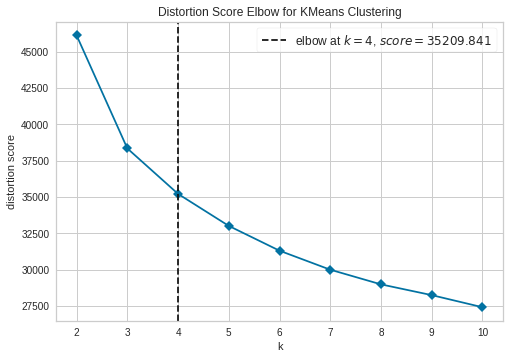

In [31]:
plot_model(kmeans, plot = 'elbow')

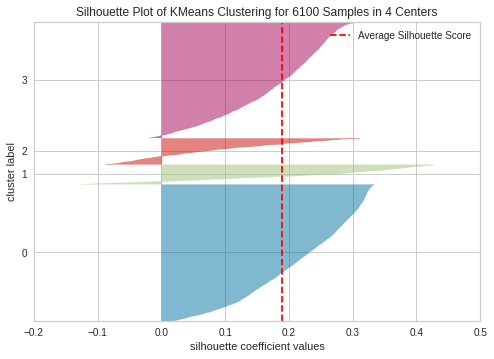

In [32]:
plot_model(kmeans, plot = 'silhouette')

## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# **Interpret results and plan for actions**

In [33]:
x = df_csv.copy()
x = x.drop(['CUST_CODE','FirstDate', 'LastDate'],axis=1)
x

,TotalSpend,TotalVisits,TotalSKUs,LifeStage,TicketSize,total_days,recency,SHOP_WEEKDAY,SHOP_HOUR,BasketType,BasketDom
0,2.44,1,1,0,2.440000,1,547,7,13,1,1
1,959.33,220,189,1,4.360591,812,1,6,17,1,1
2,328.57,16,116,0,20.535625,338,13,2,21,3,3
3,5.95,3,4,0,1.983333,65,730,1,8,1,2
4,39.74,4,24,0,9.935000,610,14,1,16,2,1
...,...,...,...,...,...,...,...,...,...,...,...
6095,453.58,30,206,4,15.119333,698,95,1,16,2,1
6096,105.11,11,46,2,9.555455,740,59,1,17,3,3
6097,5.86,1,4,0,5.860000,1,742,1,14,2,1
6098,444.17,21,127,4,21.150952,555,31,4,16,3,1


In [34]:
df_csv["Clustering"] = kmeans.fit_predict(x)

In [35]:
df_csv

,CUST_CODE,TotalSpend,TotalVisits,TotalSKUs,FirstDate,LastDate,LifeStage,TicketSize,total_days,recency,SHOP_WEEKDAY,SHOP_HOUR,BasketType,BasketDom,Clustering
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,0,2.440000,1,547,7,13,1,1,0
1,CUST0000000369,959.33,220,189,2006-04-16,2008-07-05,1,4.360591,812,1,6,17,1,1,3
2,CUST0000000689,328.57,16,116,2007-07-22,2008-06-23,0,20.535625,338,13,2,21,3,3,2
3,CUST0000000998,5.95,3,4,2006-05-04,2006-07-07,0,1.983333,65,730,1,8,1,2,0
4,CUST0000001163,39.74,4,24,2006-10-22,2008-06-22,0,9.935000,610,14,1,16,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,CUST0000999593,453.58,30,206,2006-05-06,2008-04-02,4,15.119333,698,95,1,16,2,1,2
6096,CUST0000999645,105.11,11,46,2006-04-30,2008-05-08,2,9.555455,740,59,1,17,3,3,2
6097,CUST0000999654,5.86,1,4,2006-06-25,2006-06-25,0,5.860000,1,742,1,14,2,1,0
6098,CUST0000999935,444.17,21,127,2006-11-29,2008-06-05,4,21.150952,555,31,4,16,3,1,2


In [36]:
x = df_csv.copy()
x = x.drop(['CUST_CODE','FirstDate', 'LastDate','Clustering'],axis=1)
x.columns

Index(['TotalSpend', 'TotalVisits', 'TotalSKUs', 'LifeStage', 'TicketSize',
       'total_days', 'recency', 'SHOP_WEEKDAY', 'SHOP_HOUR', 'BasketType',
       'BasketDom'],
      dtype='object')

In [37]:
y = df_csv["Clustering"]
#y = x.drop(['CUST_CODE','FirstDate', 'LastDate','Clustering'],axis=1)
y

0       0
1       3
2       2
3       0
4       2
       ..
6095    2
6096    2
6097    0
6098    2
6099    2
Name: Clustering, Length: 6100, dtype: int32

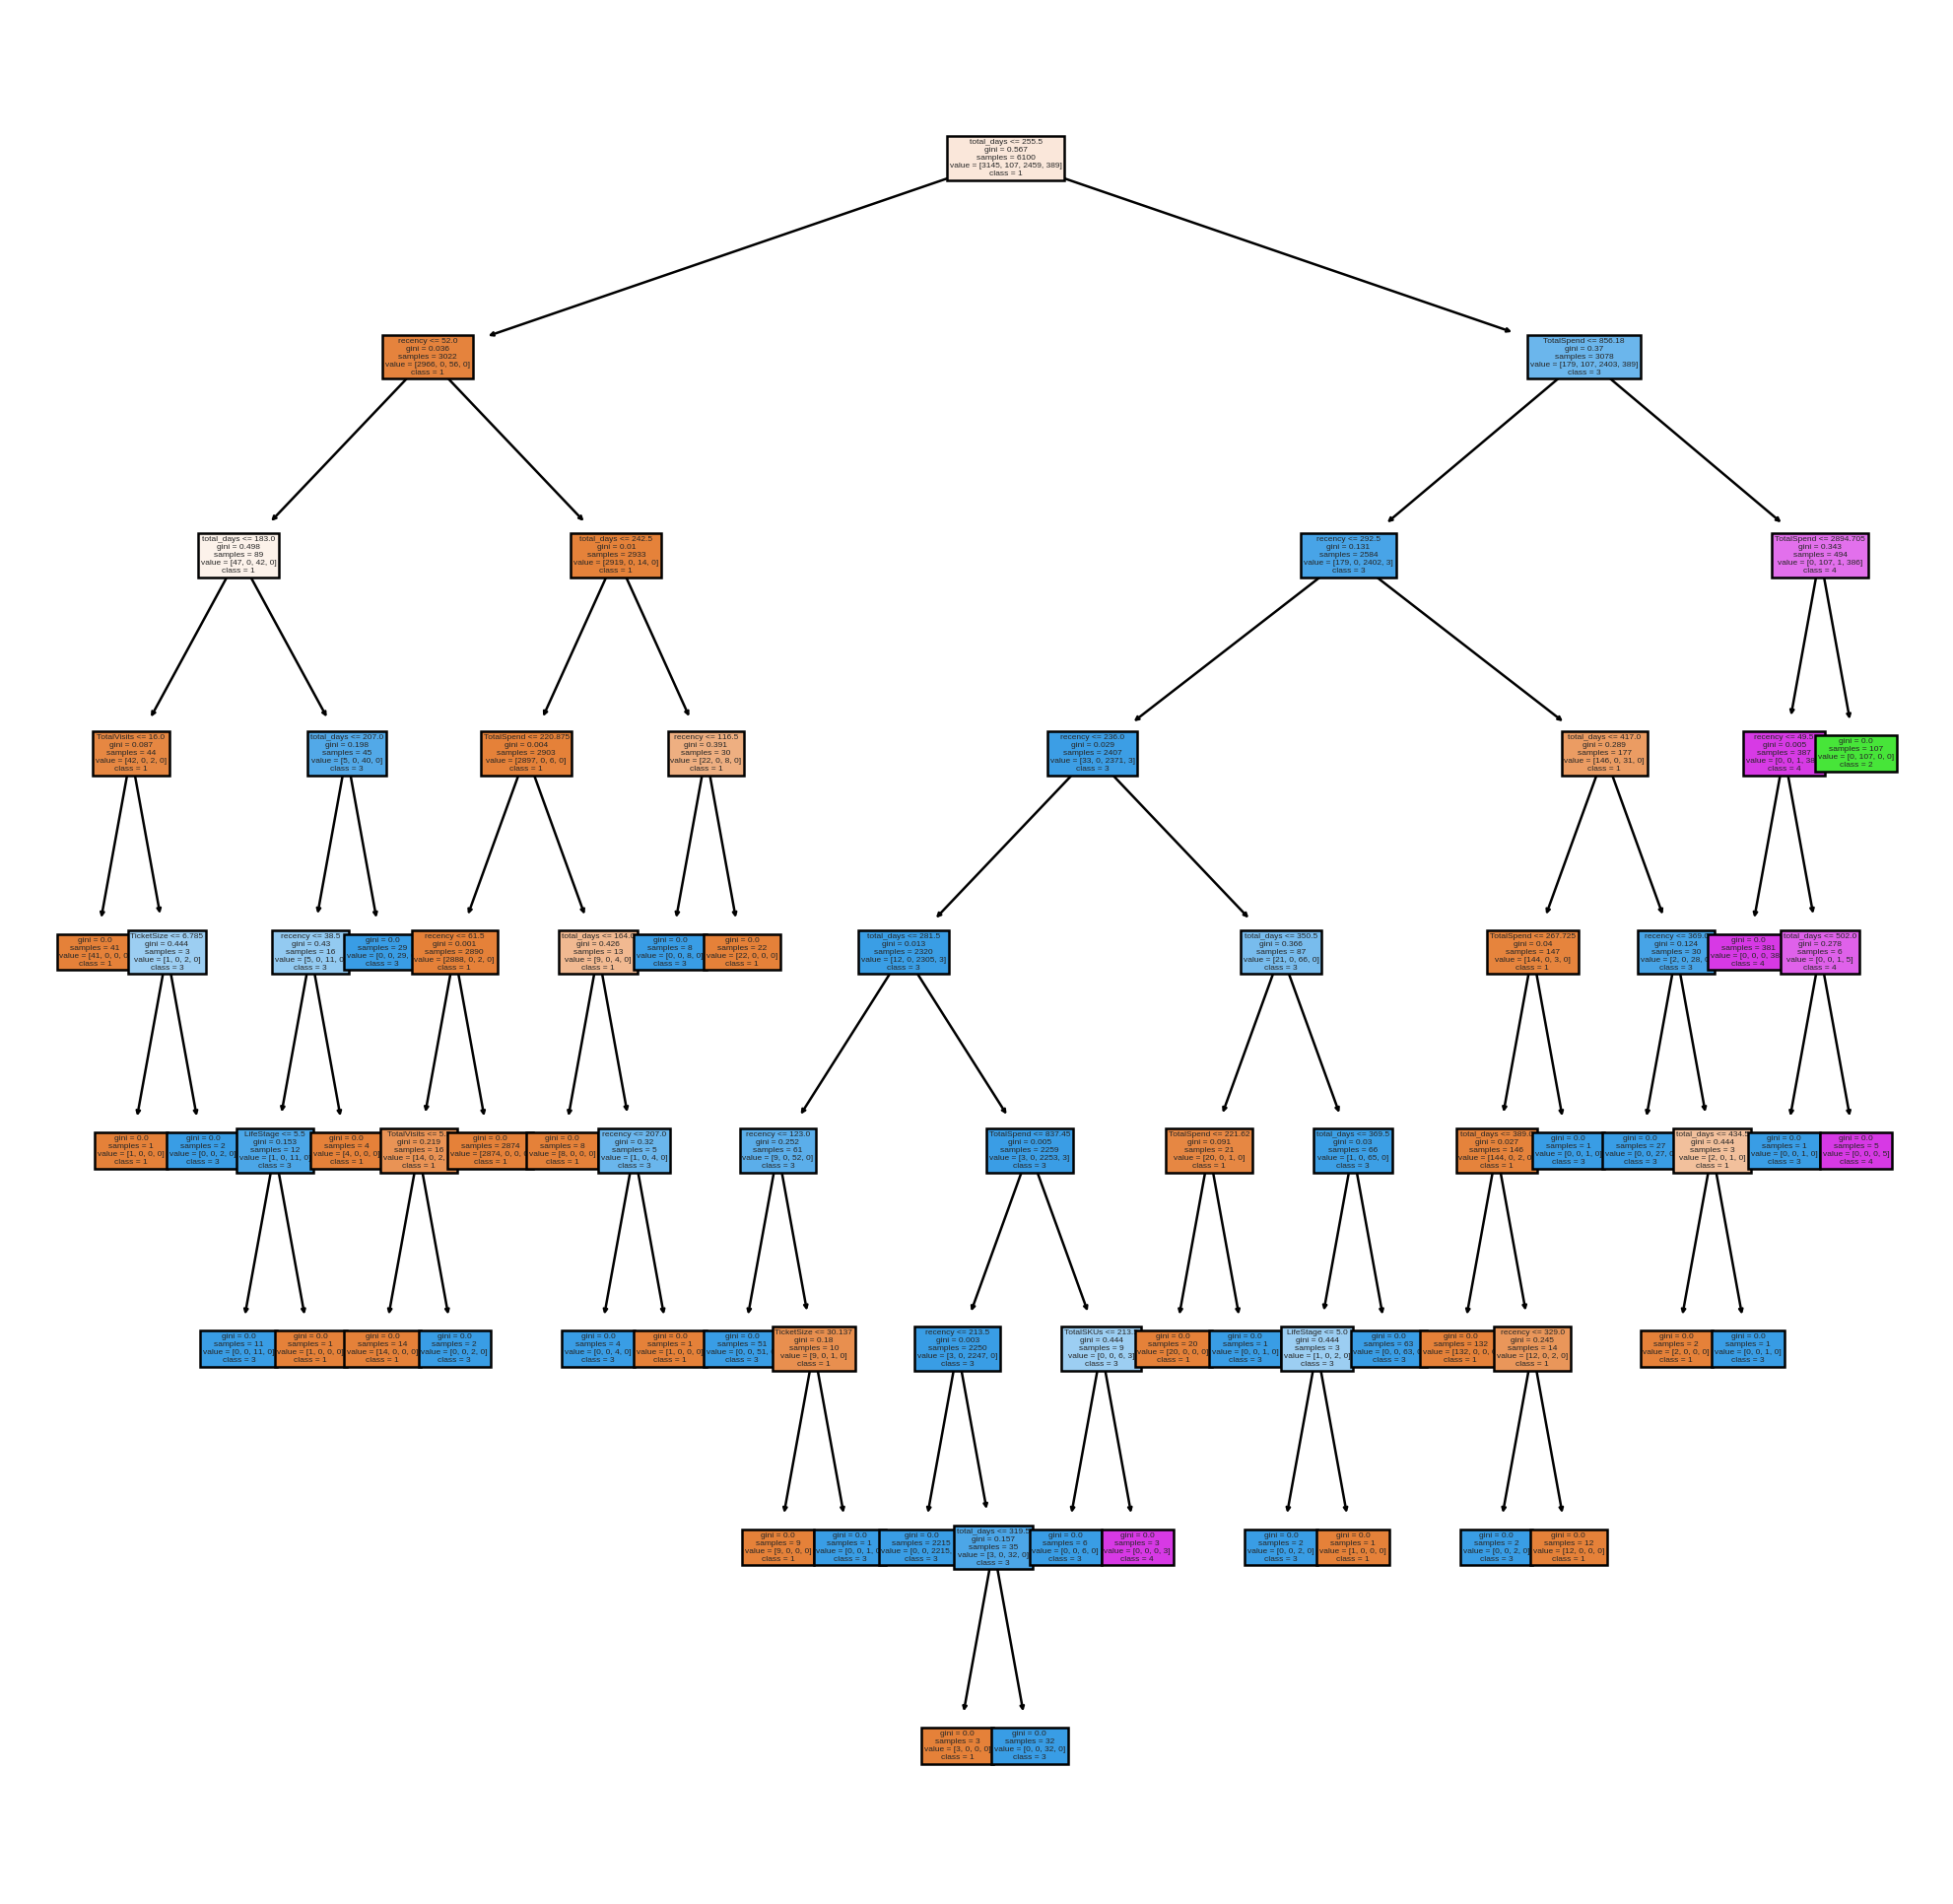

In [38]:
from sklearn import tree
import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(25,20))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(x, y)
tree.plot_tree(clf ,feature_names=x.columns,class_names=["1","2","3","4"] ,filled=True)
fig.savefig('imagename.png')

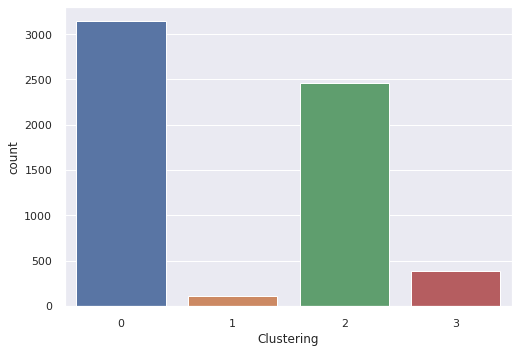

In [39]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Clustering", data=df_csv)

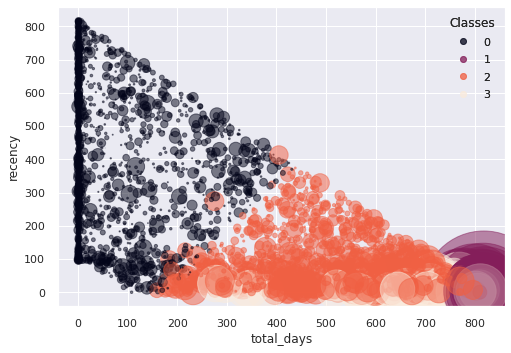

In [40]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
scatter = ax.scatter(x=df_csv["total_days"], y=df_csv["recency"], s=df_csv["TotalSpend"], c=df_csv["Clustering"], alpha=0.5)

#plt.scatter(x=df_csv["total_days"], y=df_csv["recency"], s=df_csv["TotalSpend"], c=df_csv["Clustering"], alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_ylabel('recency')
ax.set_xlabel('total_days')
plt.show()

### Analysis feature for clustering

**Class0** called **"SEED"** : Low Value - High Recency - Short Relationship
- Run analysis on the cost vs revenue of offering promotions
- Churn prediction (Lead scoring)

**Class2** called **"SPROUT"** : Low Value - Medium Recency - Medium Relationship
- Daily promotion special
- Discount speacial products, BOGO

**Class1** called **"YOUNG"** : Medium Value - Low Recency - Medium Relationshipp
- Up-selling and Cross-selling, for example:
    - Customer will receive Cash Coupon or Discount/Cashback x% when purchasing the participating products or when purchasing at x,xxx THB
    - Customer will receive Cash Coupon when Top-Up Pre-Paid gift card at xx,xxx THB
    - Customer will receive free sample or product when purchasing more the same catagory items such as free wooden storage when purchasing 4 twining tea boxs

**Class3** called **"RIPE"** : High Value -Low Recency- Long Relationship

- Send holiday gift and birthday gift ex. new product samples, gift card, discount coupon
- Offer additional privilege Cash Coupon or Discount/Cashback x% more than the other groups ex. class1 got 3% but class3 got 5%
